In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 110/110 [00:01<00:00, 104.69it/s]


In [5]:
X_train.shape

(3190, 224, 224, 3)

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

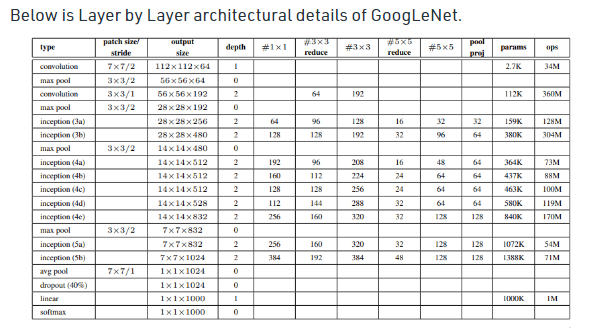

Model Build

In [10]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, \
     Concatenate, AvgPool2D, Dropout, Flatten, Dense
      
def inception_block(x, filters):
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    t4 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t4 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t4)

    output = Concatenate()([t1, t2, t3, t4])
    return output


input = Input(shape=(224, 224, 3))
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
x = AvgPool2D(pool_size=7, strides=1)(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)
x = Dense(units=2, activation='softmax')(x)


Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                          

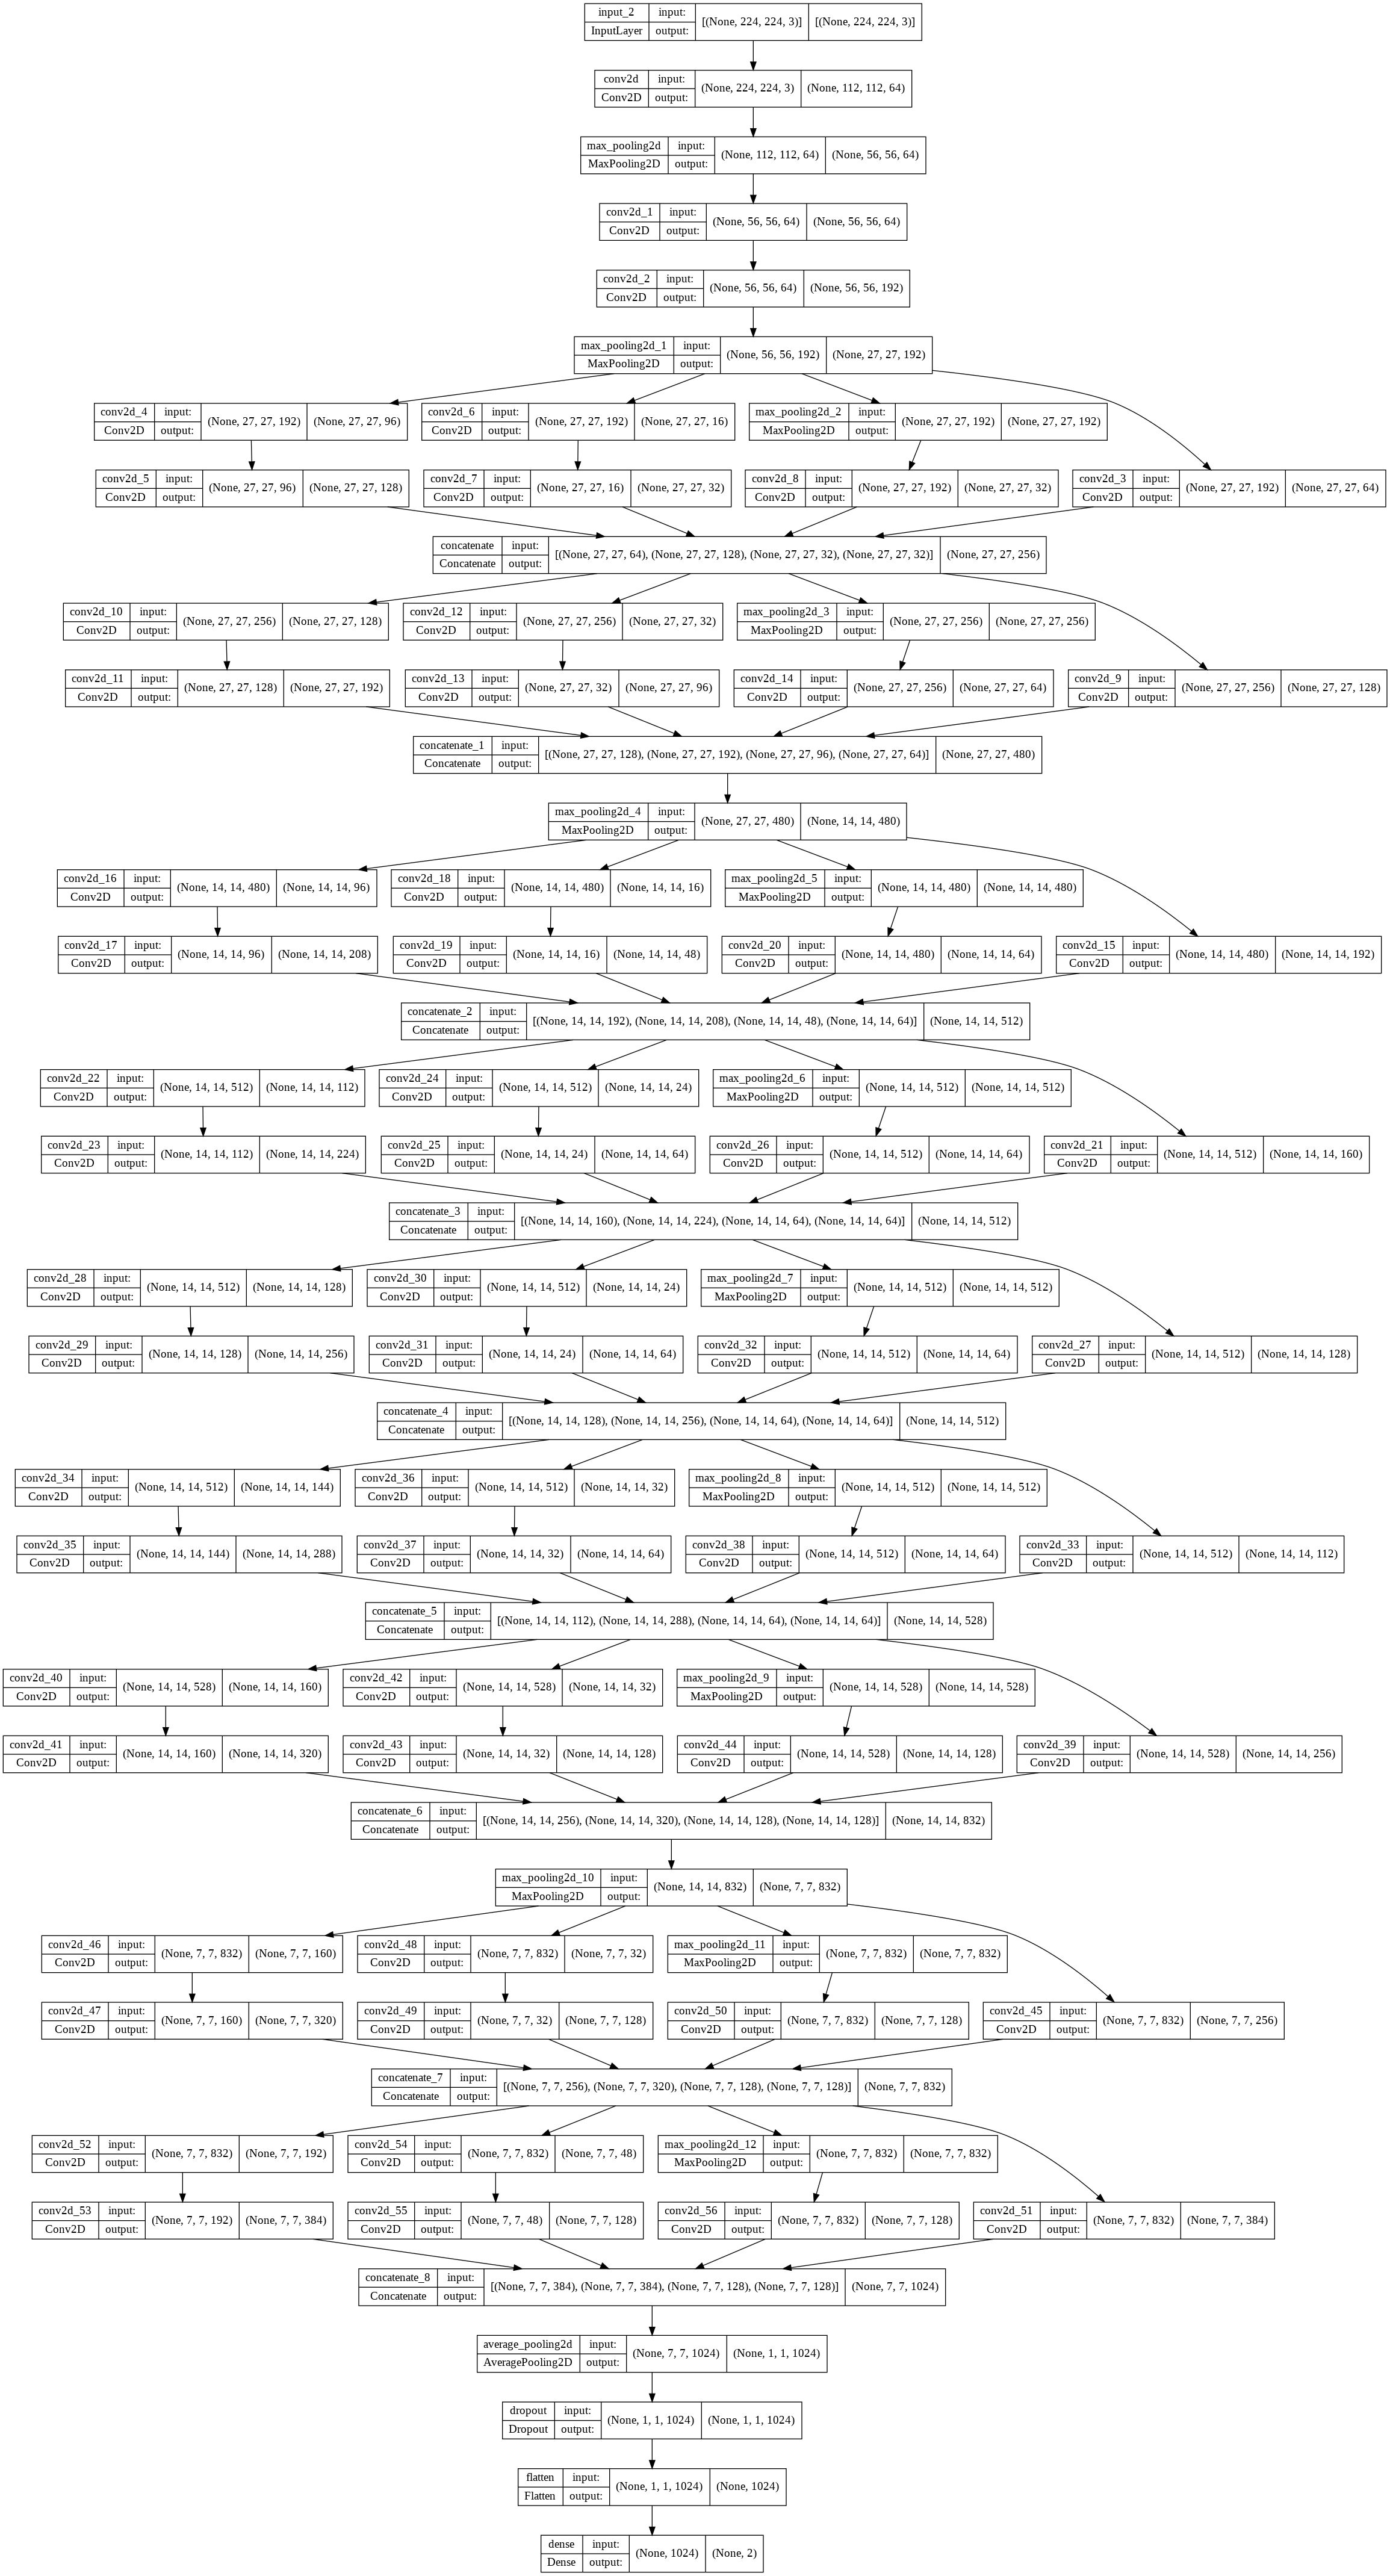

In [12]:
# Create model.
inputs = input
model =  keras.Model(inputs, x, name='GoogleNet')
model.summary()


# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='GoogleNet.png')

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("GoogLeNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [15]:
history = model.fit(X_train,y_train,validation_split=0.05, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.8960 - accuracy: 0.6260
Epoch 1: val_accuracy improved from -inf to 0.86806, saving model to GoogLeNet.h5
86/86 [==============================] - 26s 145ms/step - loss: 0.8960 - accuracy: 0.6260 - val_loss: 0.4234 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 2/50
85/86 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.6434
Epoch 2: val_accuracy did not improve from 0.86806
86/86 [==============================] - 9s 110ms/step - loss: 0.6474 - accuracy: 0.6432 - val_loss: 0.5713 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/50
85/86 [============================>.] - ETA: 0s - loss: 0.4211 - accuracy: 0.8165
Epoch 3: val_accuracy did not improve from 0.86806

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
86/86 [==============================] - 10s 111ms/step - loss: 0.4218 - accuracy: 0.8166 - val_loss: 0.3096 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 4/50
85/86 [=====

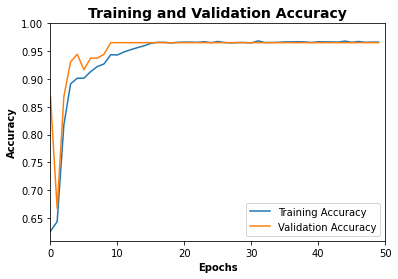

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,50])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('GoogleNetTV1',dpi=400)
plt.show()

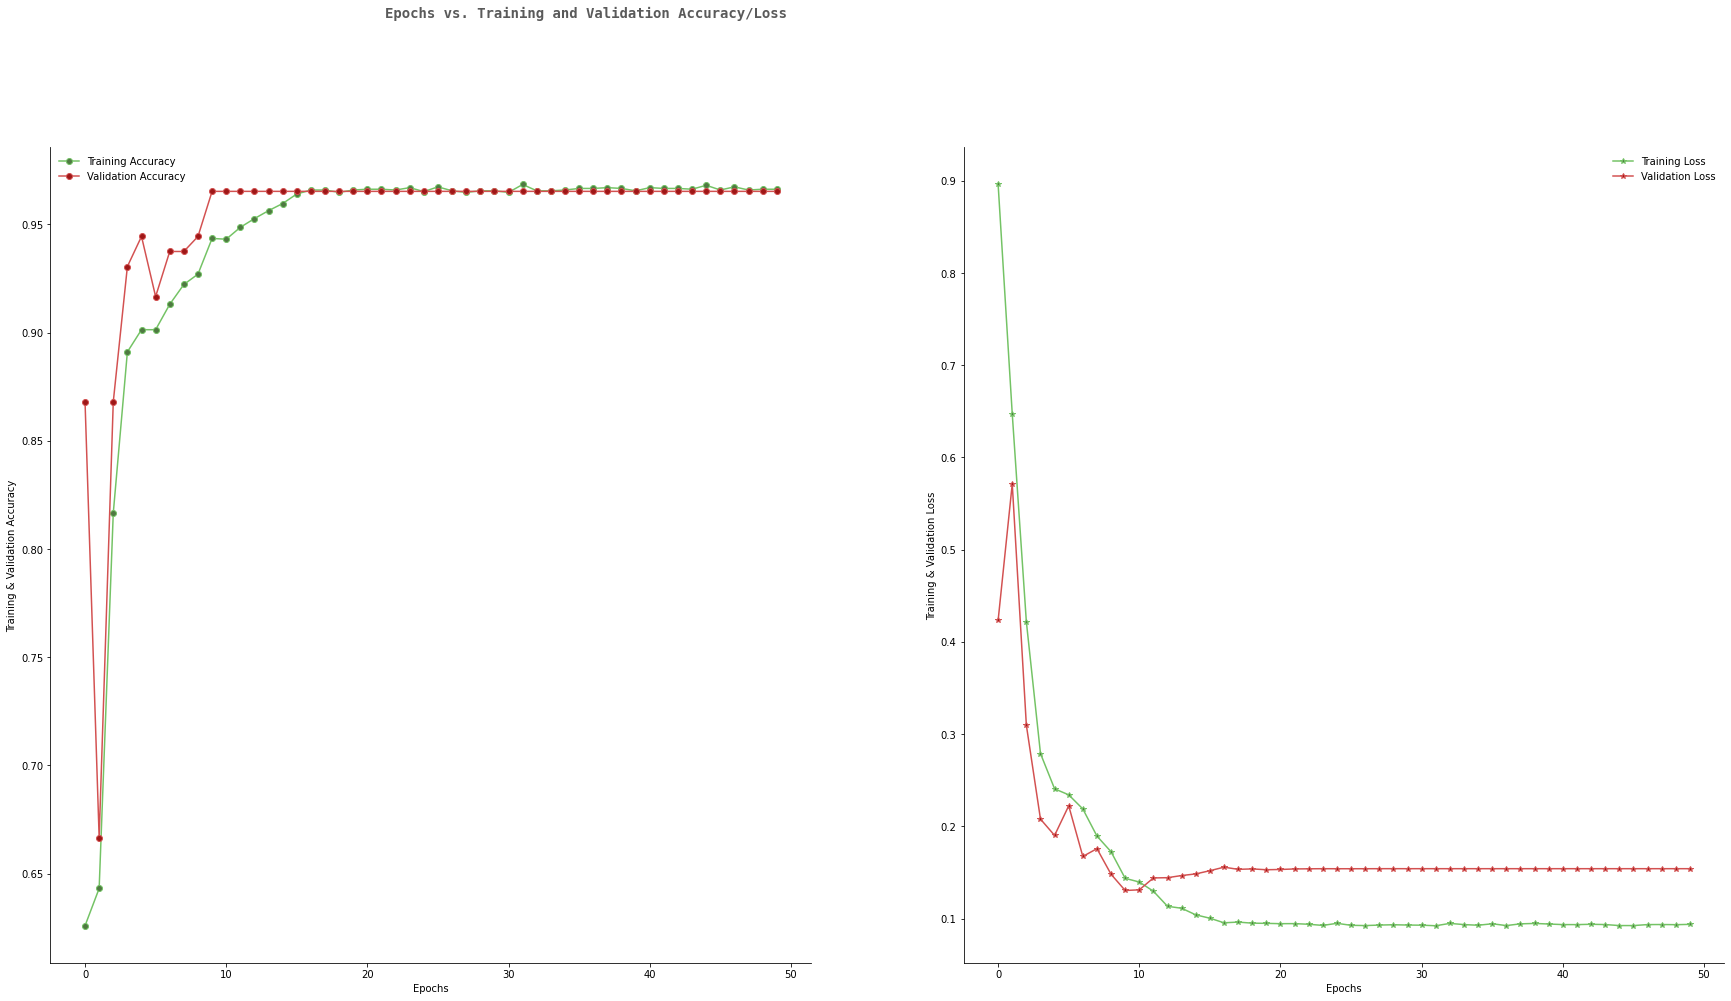

In [17]:
filterwarnings('ignore')

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2,figsize=(30,15))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='#313131',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training & Validation Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='*',markerfacecolor='#4F7942',color='#74C365',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='*',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.savefig('GoogLeNetTV2',dpi=700)
fig.show()

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [19]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       195
           1       0.93      0.93      0.93       124

    accuracy                           0.94       319
   macro avg       0.94      0.94      0.94       319
weighted avg       0.94      0.94      0.94       319



In [20]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


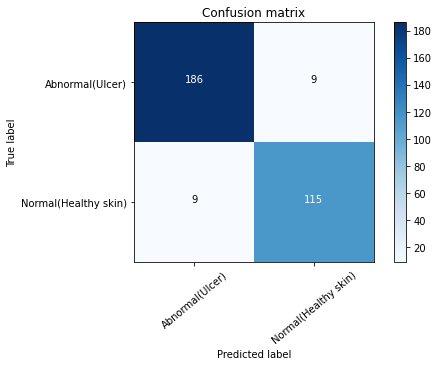

In [21]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('GoogleNetCM',dpi=400)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.944 Precision: 0.927  Recall: 0.927 F1 Score: 0.927 AUC Score: 0.941


In [23]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [24]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)

Specificity: 0.954


In [25]:
recall=TP/float(TP+FN)
print(' Recall: %.3f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.3f' % precision)

 Recall: 0.927
 Precision: 0.927


In [26]:
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.3f' % f1)

F1 Score: 0.927


In [27]:
print( 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

AUC Score: 0.941


In [28]:
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.3f' % mean_squared_error(y_test_new, pred))

Error Rate: 0.056


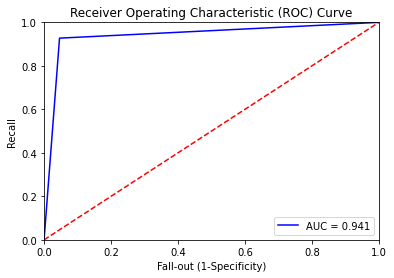

In [29]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [30]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('val_accuracy: {0:0.2f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 94.36%
Precision: 92.74%
Recall or Sensitivity: 92.74%
Specificity: 95.38%
F1-score: 92.74%
AUC-score: 94.06%
Train acc: 96.63%
val_accuracy: 96.53%
